In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns # Visualization
import matplotlib.pyplot as plt # Visualization

from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
from sklearn.model_selection import train_test_split

import warnings # Supress warnings 
warnings.filterwarnings('ignore')

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.vector_ar.vecm import coint_johansen

from itertools import product

import warnings
warnings.filterwarnings('ignore')

In [32]:
df = pd.read_csv('../Dữ liệu Lịch sử DXG.csv')
df['Ngày']=pd.to_datetime(df.Ngày, format ="%d/%m/%Y")
  # Sort the dataframe by date in ascending order
df = df.sort_values('Ngày')

In [33]:
# Rename columns
df.rename(columns={"Ngày":"Date","Lần cuối":"Close","Mở":"Open","Cao":"High","Thấp":"Low","KL": "Volume","% Thay đổi": "percent_change"}, inplace= True)


In [34]:
# convert date field from string to Date format and make it index
def tranformData(df: pd.DataFrame):
  df['Date'] = pd.to_datetime(df.Date, format='%d/%m/%Y')
  df['Close'] = df['Close'].astype(str).apply(lambda x: float(x.replace(',', '')))
  df['Open'] = df['Open'].astype(str).apply(lambda x: float(x.replace(',', '')))
  df['High'] = df['High'].astype(str).apply(lambda x: float(x.replace(',', '')))
  df['Low'] = df['Low'].astype(str).apply(lambda x: float(x.replace(',', '')))
  def convert_to_number(x):
      if 'M' in x:
          return float(x.replace('M', '')) * 1000000
      elif 'K' in x:
          return float(x.replace('K', '')) * 1000
      else:
          return float(x)
  df['Volume'] = df['Volume'].apply(convert_to_number)
  df['percent_change'] = df['percent_change'].apply(lambda x: float(x.strip('%'))/100)

In [35]:
df

,Date,Close,Open,High,Low,Volume,percent_change
1348,2017-12-01,12251.8,11949.3,12403.1,11919.0,8.61M,2.79%
1347,2017-12-04,12705.6,12463.6,12705.6,12282.1,9.42M,3.70%
1346,2017-12-05,12282.1,12705.6,12917.3,12282.1,11.06M,-3.33%
1345,2017-12-06,12161.1,12161.1,12342.6,11919.0,7.72M,-0.99%
1344,2017-12-07,12100.6,12161.1,12312.3,11858.5,5.23M,-0.50%
...,...,...,...,...,...,...,...
4,2023-04-24,12750.0,12500.0,12850.0,12500.0,7.78M,0.79%
3,2023-04-25,12550.0,12950.0,12950.0,12550.0,10.09M,-1.57%
2,2023-04-26,12600.0,12600.0,12700.0,12400.0,7.82M,0.40%
1,2023-04-27,13200.0,12700.0,13450.0,12600.0,30.21M,4.76%


In [36]:
tranformData(df)

In [37]:
#Định dạng lại cột Date từ obj -> datetime
df['Date'] = pd.to_datetime(df['Date'])
# Chuyển cột Date làm index để lập biểu đồ so sánh về sau
df.index = df.Date
df.drop('Date', axis=1, inplace=True)

In [38]:
df

,Close,Open,High,Low,Volume,percent_change
Date,,,,,,
2017-12-01,12251.8,11949.3,12403.1,11919.0,8610000.0,0.0279
2017-12-04,12705.6,12463.6,12705.6,12282.1,9420000.0,0.0370
2017-12-05,12282.1,12705.6,12917.3,12282.1,11060000.0,-0.0333
2017-12-06,12161.1,12161.1,12342.6,11919.0,7720000.0,-0.0099
2017-12-07,12100.6,12161.1,12312.3,11858.5,5230000.0,-0.0050
...,...,...,...,...,...,...
2023-04-24,12750.0,12500.0,12850.0,12500.0,7780000.0,0.0079
2023-04-25,12550.0,12950.0,12950.0,12550.0,10090000.0,-0.0157
2023-04-26,12600.0,12600.0,12700.0,12400.0,7820000.0,0.0040


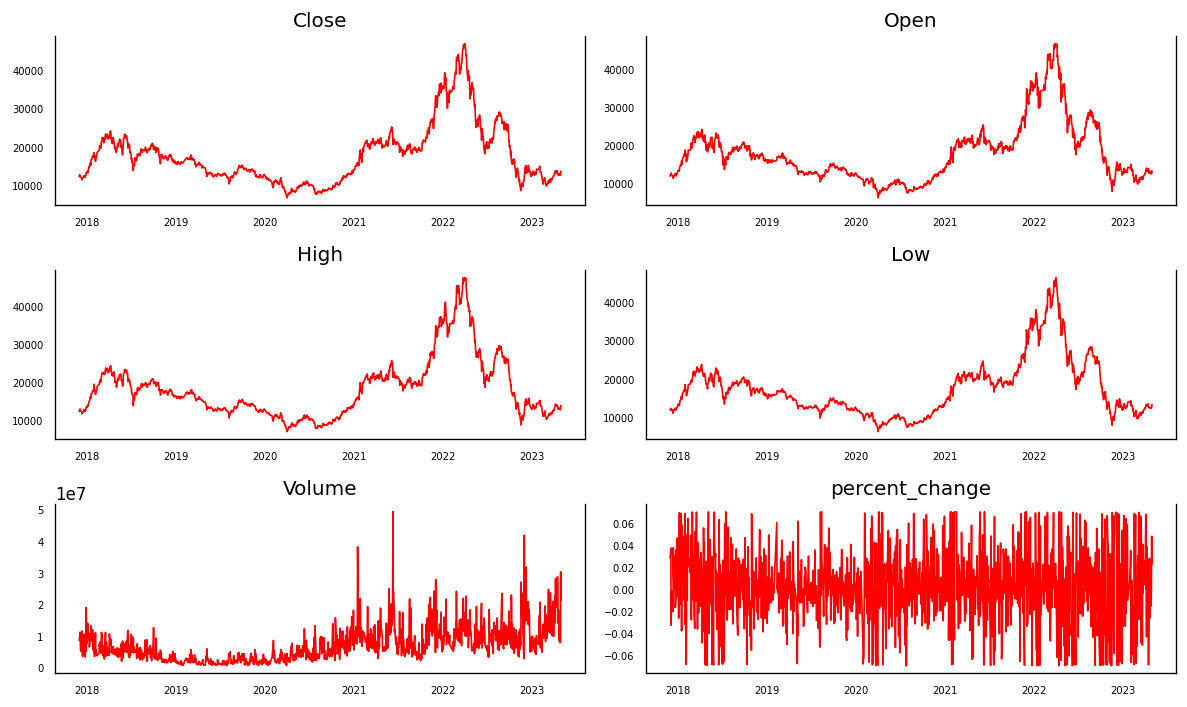

In [39]:


# Plot
fig, axes = plt.subplots(nrows=3, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();
     

In [40]:
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns)  

,Close_x,Open_x,High_x,Low_x,Volume_x,percent_change_x
Close_y,1.0000,0.0002,0.0302,0.0141,0.1147,0.0014
Open_y,0.0000,1.0000,0.0000,0.0000,0.0140,0.0000
High_y,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000
Low_y,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000
Volume_y,0.0000,0.0000,0.0000,0.0000,1.0000,0.0377
percent_change_y,0.0812,0.0324,0.1144,0.0639,0.0752,1.0000


In [41]:
def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Close  ::  712.56    > 83.9383   =>   True
Open   ::  463.72    > 60.0627   =>   True
High   ::  246.75    > 40.1749   =>   True
Low    ::  95.99     > 24.2761   =>   True
Volume ::  32.03     > 12.3212   =>   True
percent_change ::  0.46      > 4.1296    =>   False


In [42]:
nobs=int(0.2*len(df))
n_train = int(0.7 * len(df))
n_test = int(0.2 * len(df))
n_validation = len(df) - n_train - n_test
nobs_val= n_validation
df_train = df[:n_train]
df_test = df[n_train:n_train+n_test]
df_validation = df[n_train+n_test:]

# Kiểm tra kích thước
print(df_train.shape)
print(df_test.shape)
print(df_validation.shape)

(944, 6)
(269, 6)
(136, 6)


In [43]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

In [44]:
# ADF Test on each column
for name, column in df_train.items():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Close" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.5189
 No. Lags Chosen       = 4
 Critical value 1%     = -3.437
 Critical value 5%     = -2.865
 Critical value 10%    = -2.568
 => P-Value = 0.5241. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Open" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.8595
 No. Lags Chosen       = 22
 Critical value 1%     = -3.437
 Critical value 5%     = -2.865
 Critical value 10%    = -2.568
 => P-Value = 0.3513. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "High" 
    -----------------------------------------------
 Null Hypothesis: Data has unit 

In [45]:
# 1st difference
df_differenced = df_train.diff().dropna()

In [46]:
# ADF Test trên từng cột của DataFrame chứa sự khác biệt đầu tiên
for name in df_differenced.columns:
    adfuller_test(df_differenced[name], name=name)
    print('\n')


    Augmented Dickey-Fuller Test on "Close" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -16.927
 No. Lags Chosen       = 3
 Critical value 1%     = -3.437
 Critical value 5%     = -2.865
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Open" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.7519
 No. Lags Chosen       = 22
 Critical value 1%     = -3.437
 Critical value 5%     = -2.865
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "High" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.0

In [47]:
# Second Differencing
df_differenced = df_differenced.diff().dropna()

In [48]:
# ADF Test on each column of 2nd Differences Dataframe
for name, column in df_differenced.items():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Close" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -12.0543
 No. Lags Chosen       = 20
 Critical value 1%     = -3.437
 Critical value 5%     = -2.865
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Open" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -12.6077
 No. Lags Chosen       = 20
 Critical value 1%     = -3.437
 Critical value 5%     = -2.865
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "High" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 

In [49]:
model = VAR(df_differenced)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  69.17052341203932
BIC :  69.3868588125309
FPE :  1.0974313018269399e+30
HQIC:  69.25298822908168 

Lag Order = 2
AIC :  67.55028338699226
BIC :  67.95238831281205
FPE :  2.171300445917592e+29
HQIC:  67.70356948374439 

Lag Order = 3
AIC :  66.59079610326386
BIC :  67.1789845639984
FPE :  8.318206322888436e+28
HQIC:  66.8150304614212 

Lag Order = 4
AIC :  65.9590507603433
BIC :  66.73363763918226
FPE :  4.422671474131114e+28
HQIC:  66.25436072395705 

Lag Order = 5
AIC :  65.55040528703957
BIC :  66.51170634413279
FPE :  2.9392887520555477e+28
HQIC:  65.91691856392853 

Lag Order = 6
AIC :  65.22958981032993
BIC :  66.37792168616114
FPE :  2.1328401993541458e+28
HQIC:  65.66743447349955 

Lag Order = 7
AIC :  65.00103066499837
BIC :  66.33671088377535
FPE :  1.6972980904614847e+28
HQIC:  65.5103351540666 

Lag Order = 8
AIC :  64.83638740920055
BIC :  66.35973438226188
FPE :  1.4399139214113764e+28
HQIC:  65.41728053183084 

Lag Order = 9
AIC :  64.72716724620444
B

In [50]:
x = model.select_order(maxlags=20)
x.summary()

,AIC,BIC,FPE,HQIC
0,73.84,73.87,1.170e+32,73.85
1,69.21,69.43,1.145e+30,69.30
2,67.59,67.99,2.251e+29,67.74
3,66.62,67.22,8.550e+28,66.85
4,65.98,66.76,4.500e+28,66.28
5,65.57,66.54,2.990e+28,65.94
6,65.25,66.42,2.186e+28,65.70
7,65.02,66.37*,1.736e+28,65.54
8,64.86,66.40,1.479e+28,65.45
9,64.75,66.48,1.319e+28,65.41


In [51]:
model_fitted = model.fit(14)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 14, Jun, 2023
Time:                     23:00:54
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                    66.9102
Nobs:                     928.000    HQIC:                   65.2673
Log likelihood:          -37204.6    FPE:                8.06391e+27
AIC:                      64.2541    Det(Omega_mle):     4.76625e+27
--------------------------------------------------------------------
Results for equation Close
                        coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------
const                      0.212054        15.248481            0.014           0.989
L1.Close                  -0.825167         0.129667           -6.364           0.000
L1.Open                   -0.056212     

In [52]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

14


array([[-1.3040e+02,  2.6080e+02,  3.0430e+02, -2.1750e+02,  1.0300e+06,
        -6.2100e-02],
       [-1.7390e+02,  1.1304e+03,  5.6530e+02,  6.0870e+02,  4.5000e+05,
        -2.3000e-03],
       [ 8.2610e+02, -1.0434e+03, -8.7000e+01, -5.6520e+02,  2.2200e+06,
         5.4900e-02],
       [-1.3050e+02,  1.7391e+03,  6.0860e+02,  1.3913e+03,  3.0700e+06,
        -5.3600e-02],
       [-5.6520e+02, -1.4782e+03, -1.0433e+03, -1.3043e+03, -5.8800e+06,
        -2.1700e-02],
       [-4.3400e+01, -3.9140e+02,  2.1730e+02,  1.3040e+02,  4.0000e+05,
         2.7600e-02],
       [ 7.8250e+02,  1.0435e+03,  6.5210e+02,  3.9130e+02,  7.8100e+06,
         4.3000e-02],
       [-1.4782e+03, -2.1740e+02, -7.8250e+02, -8.2610e+02, -1.1240e+07,
        -1.1620e-01],
       [ 7.8260e+02, -1.1304e+03, -3.9130e+02,  3.4790e+02,  6.4700e+06,
         1.1480e-01],
       [ 5.6960e+02,  1.3022e+03,  9.4340e+02,  5.1730e+02, -2.3500e+06,
        -9.5000e-03],
       [-1.0196e+03, -3.6960e+02, -4.2170e+02, -5.

In [53]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[n_train:n_train+n_test], columns=df.columns + '_2d')
df_forecast

,Close_2d,Open_2d,High_2d,Low_2d,Volume_2d,percent_change_2d
Date,,,,,,
2021-09-16,-96.369628,1199.196825,681.600194,490.969562,3.506251e+06,-4.799954e-02
2021-09-17,-150.249588,-664.425560,-478.930396,-237.266278,4.713048e+05,-1.781870e-03
2021-09-20,297.656038,306.419860,290.834270,124.058209,-3.122186e+06,1.787329e-02
2021-09-21,-167.503715,-178.038331,-174.458762,-51.379188,1.418728e+06,-2.083387e-02
2021-09-22,104.975776,14.769544,209.130754,34.572682,6.385321e+05,1.328218e-02
...,...,...,...,...,...,...
2022-10-06,0.030400,0.030097,0.025122,0.034338,-2.582402e+02,-2.565741e-08
2022-10-07,0.030400,0.030097,0.025122,0.034338,-2.582400e+02,-2.565804e-08
2022-10-10,0.030400,0.030097,0.025122,0.034338,-2.582391e+02,-2.565822e-08


In [54]:
# Forecast val
fc_val = model_fitted.forecast(y=forecast_input, steps=nobs_val)
df_forecast_val = pd.DataFrame(fc_val, index=df.index[n_train+n_test:], columns=df.columns + '_2d')
df_forecast_val

,Close_2d,Open_2d,High_2d,Low_2d,Volume_2d,percent_change_2d
Date,,,,,,
2022-10-13,-96.369628,1199.196825,681.600194,490.969562,3.506251e+06,-4.799954e-02
2022-10-14,-150.249588,-664.425560,-478.930396,-237.266278,4.713048e+05,-1.781870e-03
2022-10-17,297.656038,306.419860,290.834270,124.058209,-3.122186e+06,1.787329e-02
2022-10-18,-167.503715,-178.038331,-174.458762,-51.379188,1.418728e+06,-2.083387e-02
2022-10-19,104.975776,14.769544,209.130754,34.572682,6.385321e+05,1.328218e-02
...,...,...,...,...,...,...
2023-04-24,0.030309,0.028963,0.027554,0.032379,-2.500289e+02,-2.424647e-07
2023-04-25,0.025672,0.029711,0.023372,0.035134,-2.202586e+02,-1.748465e-07
2023-04-26,0.033240,0.029235,0.024098,0.033650,-2.872941e+02,3.430066e-07


In [55]:
def invert_transformation(df_train, df_forecast_val, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc_val = df_forecast_val.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc_val[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc_val[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc_val[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc_val[str(col)+'_1d'].cumsum()
    return df_fc_val

In [56]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [57]:
df_results_val = invert_transformation(df_train, df_forecast_val, second_diff=True)        
df_results_val.loc[:, ['Close_forecast', 'Open_forecast', 'High_forecast', 'Low_forecast',
                   'Volume_forecast', 'percent_change_forecast']]

,Close_forecast,Open_forecast,High_forecast,Low_forecast,Volume_forecast,percent_change_forecast
Date,,,,,,
2022-10-13,18853.630372,19099.196825,19281.600194,18640.969562,3.206251e+06,0.007500
2022-10-14,18807.011157,18983.968091,19184.269992,18694.672845,4.593806e+06,0.002419
2022-10-17,19058.047980,19175.159217,19377.774059,18872.434338,2.859175e+06,0.015211
2022-10-18,19141.581088,19188.312011,19396.819365,18998.816643,2.543273e+06,0.007169
2022-10-19,19330.089972,19216.234349,19624.995424,19159.771630,2.865902e+06,0.012409
...,...,...,...,...,...,...
2023-04-24,20526.418545,21684.517356,20545.432154,22434.356390,-3.317663e+07,0.030352
2023-04-25,20539.176000,21704.851544,20555.159438,22463.151951,-3.347366e+07,0.030564
2023-04-26,20551.966695,21725.214967,20564.910819,22491.981163,-3.377097e+07,0.030776


In [58]:
df_results = invert_transformation(df_train, df_forecast, second_diff=True)        
df_results.loc[:, ['Close_forecast', 'Open_forecast', 'High_forecast', 'Low_forecast',
                   'Volume_forecast', 'percent_change_forecast']]

,Close_forecast,Open_forecast,High_forecast,Low_forecast,Volume_forecast,percent_change_forecast
Date,,,,,,
2021-09-16,18853.630372,19099.196825,19281.600194,18640.969562,3.206251e+06,0.007500
2021-09-17,18807.011157,18983.968091,19184.269992,18694.672845,4.593806e+06,0.002419
2021-09-20,19058.047980,19175.159217,19377.774059,18872.434338,2.859175e+06,0.015211
2021-09-21,19141.581088,19188.312011,19396.819365,18998.816643,2.543273e+06,0.007169
2021-09-22,19330.089972,19216.234349,19624.995424,19159.771630,2.865902e+06,0.012409
...,...,...,...,...,...,...
2022-10-06,22490.421205,24653.212034,22059.724027,26565.470996,-7.495201e+07,0.058338
2022-10-07,22507.225005,24677.549557,22072.792845,26598.832653,-7.528342e+07,0.058547
2022-10-10,22524.059206,24701.917177,22085.886784,26632.228648,-7.561508e+07,0.058756


In [59]:
# Chuyển đổi dự đoán về đơn vị ban đầu
df_future = pd.DataFrame(fc, columns=[col + '_2d' for col in df.columns])

def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to the original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col) + '_1d'] = (df_train[col].iloc[-1] - df_train[col].iloc[-2]) + df_fc[col + '_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col) + '_forecast'] = df_train[col].iloc[-1] + df_fc[col + '_1d'].cumsum()
    return df_fc

df_future_results = invert_transformation(df_train, df_future, second_diff=True)
df_future_results.loc[:, ['Close_forecast', 'Open_forecast', 'High_forecast', 'Low_forecast', 'Volume_forecast', 'percent_change_forecast']]


,Close_forecast,Open_forecast,High_forecast,Low_forecast,Volume_forecast,percent_change_forecast
0,18853.630372,19099.196825,19281.600194,18640.969562,3.206251e+06,0.007500
1,18807.011157,18983.968091,19184.269992,18694.672845,4.593806e+06,0.002419
2,19058.047980,19175.159217,19377.774059,18872.434338,2.859175e+06,0.015211
3,19141.581088,19188.312011,19396.819365,18998.816643,2.543273e+06,0.007169
4,19330.089972,19216.234349,19624.995424,19159.771630,2.865902e+06,0.012409
...,...,...,...,...,...,...
264,22490.421205,24653.212034,22059.724027,26565.470996,-7.495201e+07,0.058338
265,22507.225005,24677.549557,22072.792845,26598.832653,-7.528342e+07,0.058547
266,22524.059206,24701.917177,22085.886784,26632.228648,-7.561508e+07,0.058756
267,22540.923807,24726.314893,22099.005845,26665.658981,-7.594700e+07,0.058964


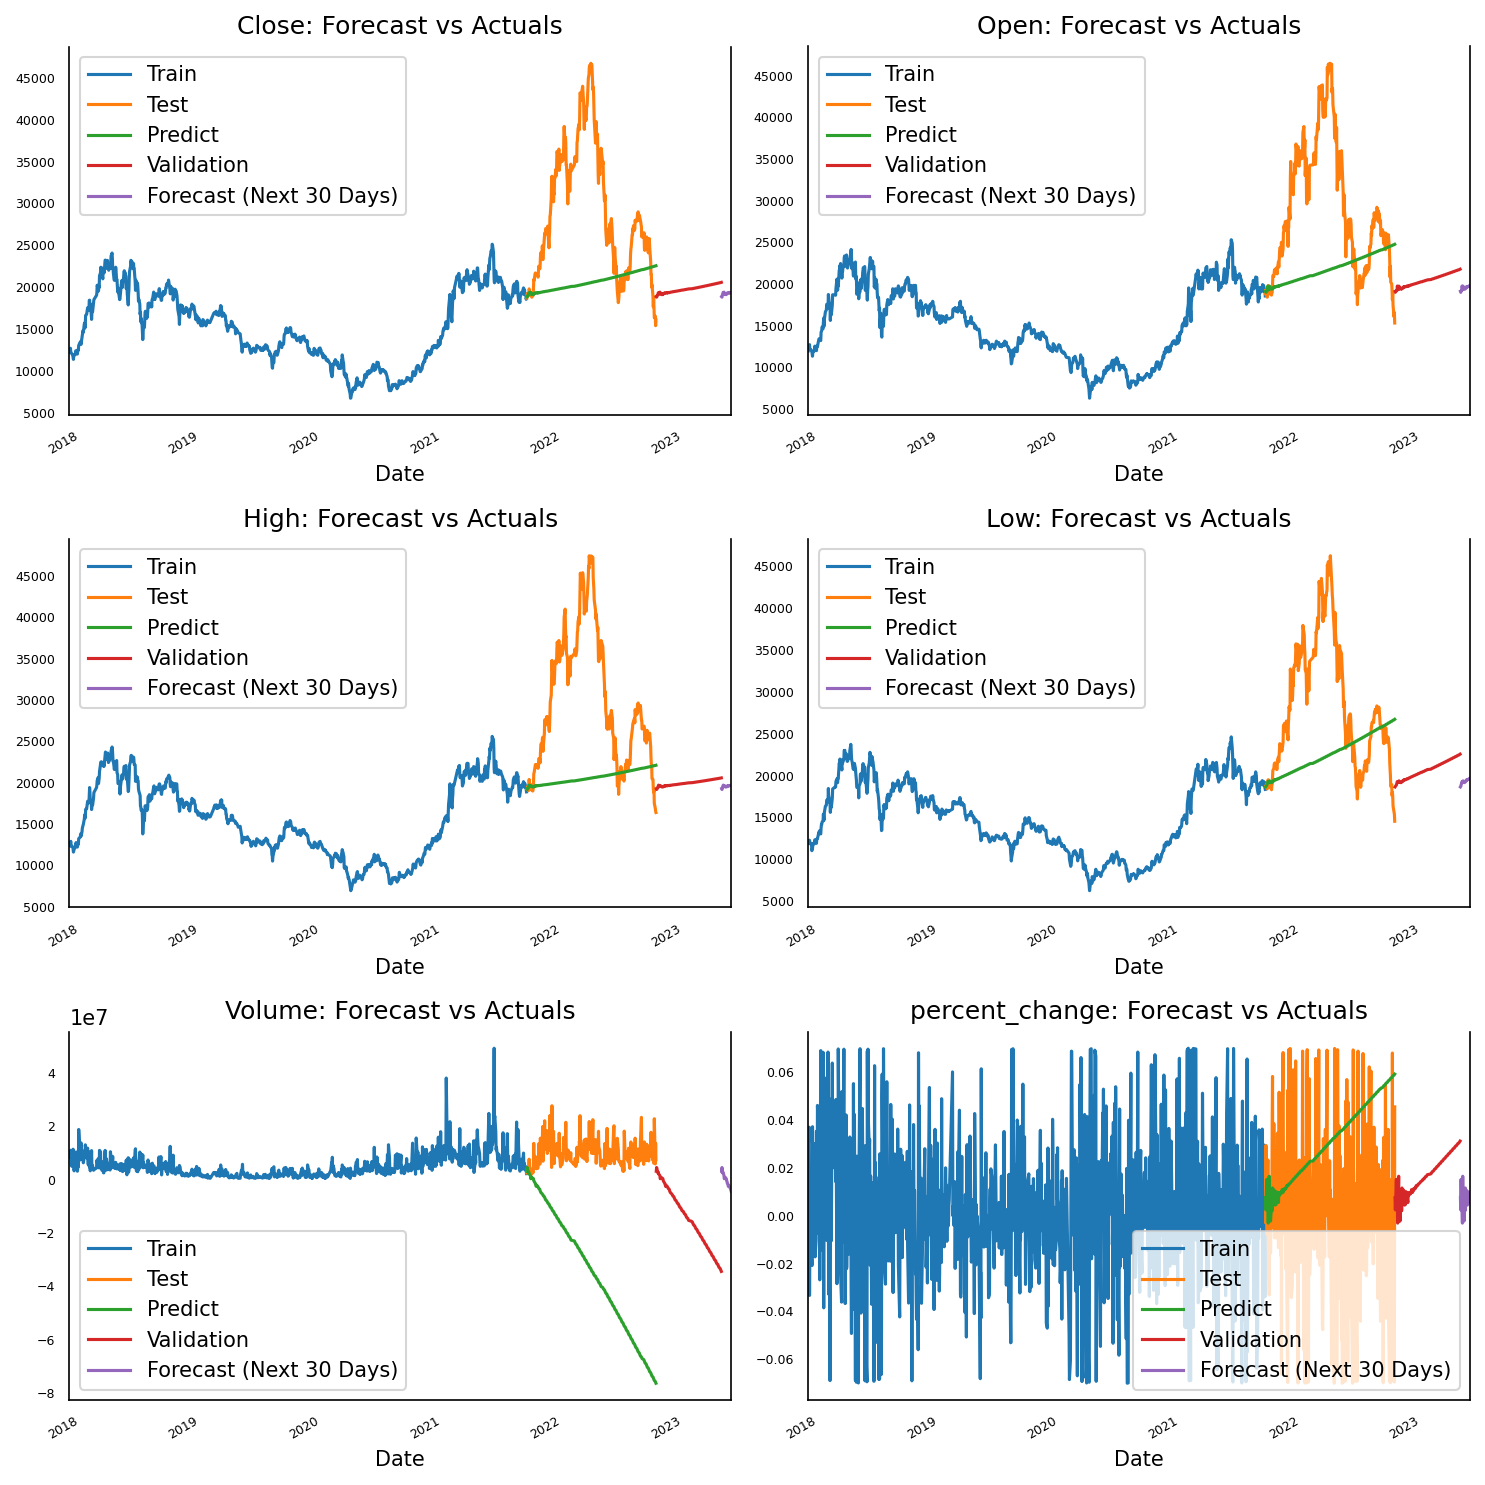

In [60]:
import datetime

# Sử dụng model_fitted để dự đoán 30 ngày tiếp theo
n_forecast_days = 30
fc = model_fitted.forecast(y=forecast_input, steps=n_forecast_days)

# Chuyển đổi dự đoán thành DataFrame
df_future = pd.DataFrame(fc, columns=[col + '_2d' for col in df.columns])

# Chuyển đổi dự đoán về đơn vị ban đầu
df_future_results = invert_transformation(df_train, df_future, second_diff=True)

# Tạo index cho 30 ngày tiếp theo
future_dates = pd.date_range(start=df.index[-1] + datetime.timedelta(days=1), periods=n_forecast_days, freq='D')

# Tạo DataFrame chứa dự đoán cho 30 ngày tiếp theo
df_future_forecast = pd.DataFrame(df_future_results.values, index=future_dates, columns=df_future_results.columns)

# Vẽ đồ thị
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col, ax) in enumerate(zip(df.columns, axes.flatten())):
    df_train[col].plot(legend=True, ax=ax, label='Train')
    df_test[col][-nobs:].plot(legend=True, ax=ax, label='Test')
    
    df_results[col+'_forecast'].plot(legend=True, ax=ax, label='Predict').autoscale(axis='x', tight=True)
    df_results_val[col+'_forecast'].plot(legend=True, ax=ax, label='Validation').autoscale(axis='x', tight=True)
    df_future_forecast[col + '_forecast'].plot(legend=True, ax=ax, label='Forecast (Next 30 Days)')
    
    
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)
plt.tight_layout()
